In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt

### data functions

In [17]:
def sp_to_cart(sp):
    """
    Converts spherical data to cartesian.

    Inputs:
    sp: spherical data np array of shape (n, 3)
    """

    sp_cart = np.ones_like(sp)
    sp_cart[:, 0] = sp[:, 0] * np.sin(sp[:, 1]) * np.cos(sp[:, 2])
    sp_cart[:, 1] = sp[:, 0] * np.sin(sp[:, 1]) * np.sin(sp[:, 2])
    sp_cart[:, 2] = sp[:, 0] * np.cos(sp[:, 1])

    return sp_cart

def gen_sphere_data(r_max, theta_max, phi_max, dr, dt, dp, bc_prop=0.1):
    """
    Generates points in sphere. Splits data into collocation and boundary
    condition subsets. Returns cartesian and spherical np arrays. 
    Also returns np array of sphere that approximates the space of interest 
    for calculating prediction normalization constant.

    Inputs:
    r_max: maximum radius 
    theta_max: maximum theta angle 
    phi_max: maximum phi angle 
    dr: radius step size
    dt: theta step size
    dp: phi step size
    bc_prop: proportion of data to be boundary condition data (1 - bc_prop = proportion of data to be collocation data)
    """

    # generate r, theta, phi values to make sphere
    r = np.arange(dr, r_max + dr, dr)
    theta = np.arange(0, theta_max, dt)
    phi = np.arange(0, phi_max, dp)

    # stack all coords (generates all points in sphere)
    full_sp = np.stack(np.meshgrid(r, theta, phi, indexing='ij'), axis=-1).reshape(-1, 3) 

    # split collocation and boundary data
    coll_data_sp = full_sp[full_sp[:, 0] < r_max]
    bc_data_sp = full_sp[full_sp[:, 0] >= r_max]

    # over/under sample coll data to fit desired bc_prop
    coll_target_N = int(bc_data_sp.shape[0] / bc_prop) - bc_data_sp.shape[0]
    if (coll_data_sp.shape[0] < coll_target_N):
        # oversample
        remaining_N = coll_target_N - coll_data_sp.shape[0]
        np.random.shuffle(coll_data_sp)
        oversampled_coll = coll_data_sp[np.random.choice([i for i, _ in enumerate(coll_data_sp)], size=remaining_N)]  # TODO perturb these? might be fine since they get perturbed in training anyways
        coll_data_sp = np.concatenate([coll_data_sp, oversampled_coll])
    elif (coll_data_sp.shape[0] > coll_target_N):
        # undersample
        np.random.shuffle(coll_data_sp)
        coll_data_sp = coll_data_sp[:coll_target_N]

    # convert to cartesian
    coll_data_cart = sp_to_cart(coll_data_sp)
    bc_data_cart = sp_to_cart(bc_data_sp)

    # bc u values
    bc_u = np.array([0.] * bc_data_cart.shape[0]).reshape(-1, 1)

    print(f"initial sphere shape: {full_sp.shape}")
    print(f"collocation data shape: {coll_data_cart.shape}")
    print(f"boundary condition data shape: {bc_data_cart.shape}")
    print(f"total N after over/under sample: {coll_data_cart.shape[0] + bc_data_cart.shape[0]}")

    # generate sphere of full approximate domain
    # NOTE hardcoded values (empirically determined this sphere is representative for normalization)
    dr = 0.5
    dt = 0.2
    dp = 0.2
    theta_max = np.pi
    phi_max = 2 * np.pi
    rs = np.arange(dr, r_max + dr, dr)
    thetas = np.arange(0, theta_max, dt)
    phis = np.arange(0, phi_max, dp)
    approx_full_sp = np.stack(np.meshgrid(rs, thetas, phis, indexing='ij'), axis=-1).reshape(-1, 3) 
    approx_full_cart = sp_to_cart(approx_full_sp)
    print(f"approx. sphere shape: {approx_full_sp.shape}")

    return coll_data_cart, bc_data_cart, bc_u, coll_data_sp, bc_data_sp, approx_full_sp, approx_full_cart

def perturb(vals, minimum, maximum, perturb_delta):
    """
    Perturbs tensor of vals. Returns tensor of same shape.

    Inputs:
    vals: tensor of data to perturb (single column with shape (n, 1))
    minimum: minimum value in vals
    maximum: maximum value in vals
    perturb_delta: proportion used to calculate noise 
    """

    # add noise to vals
    noise = torch.randn_like(vals) * perturb_delta
    new_vals = vals + noise
    
    # if perturbed vals fall outside of vals domain, move them back in
    new_vals.data[new_vals < minimum] = minimum - new_vals.data[new_vals < minimum]  
    new_vals.data[new_vals > maximum] = 2 * maximum - new_vals.data[new_vals > maximum]  

    return new_vals

def perturb_data(data, perturb_delta=0.01):
    """
    Perturbs input data to network. Returns perturbed tensor of same shape.

    Inputs:
    data: tensor of data with shape (n, 3)
    perturb_delta: proportion used to calculate noise 
    """

    new_data = torch.ones_like(data)
    minimums = [torch.min(data[:, i]).item() for i in range(data.shape[1])]
    maximums = [torch.max(data[:, i]).item() for i in range(data.shape[1])]
    perturb_deltas = [(torch.max(data[:, i]) - torch.min(data[:, i])).item() * perturb_delta for i in range(data.shape[1])]

    for i in range(data.shape[1]):
        new_data[:, i] = perturb(data[:, i], minimums[i], maximums[i], perturb_delta=perturb_deltas[i])

    return new_data

def visualize(xyz_data):
    """
    Creates 3D plot of xyz_data.

    Inputs:
    xyz_data: np array of shape (n, 3)
    """

    # 3D xyz plot
    xyzd = xyz_data
    fig = plt.figure(figsize=(8, 6), constrained_layout=True)
    ax = fig.add_subplot(projection='3d')
    scatter_ax = ax.scatter(xyzd[:, 0], xyzd[:, 1], xyzd[:, 2], c=[1. for _ in range(xyzd.shape[0])], cmap="Reds")
    colorbar = fig.colorbar(scatter_ax, shrink=0.55, aspect=6, pad=0.1)
    colorbar.remove()
    ax.set_xlabel("x", weight="bold")
    ax.set_ylabel("y", weight="bold")
    ax.set_zlabel("z", weight="bold")
    ax.zaxis.labelpad = 5
    ax.set_box_aspect(aspect=None, zoom=0.9)  
    plt.show()

### generate data

initial sphere shape: (403200, 3)
collocation data shape: (18144, 3)
boundary condition data shape: (2016, 3)
total N after over/under sample: 20160
approx. sphere shape: (20480, 3)

approximate sphere domain:


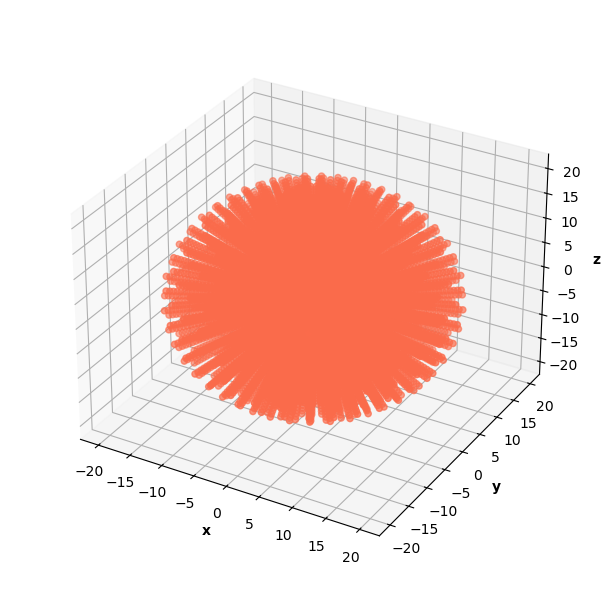

test collocation:


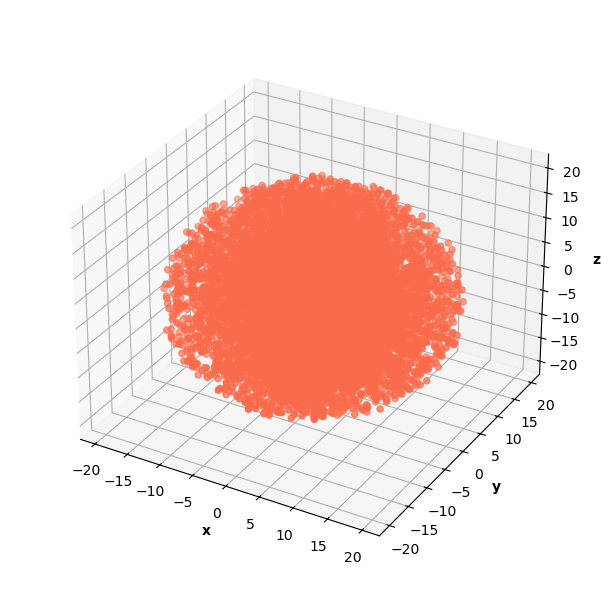

test b.c.:


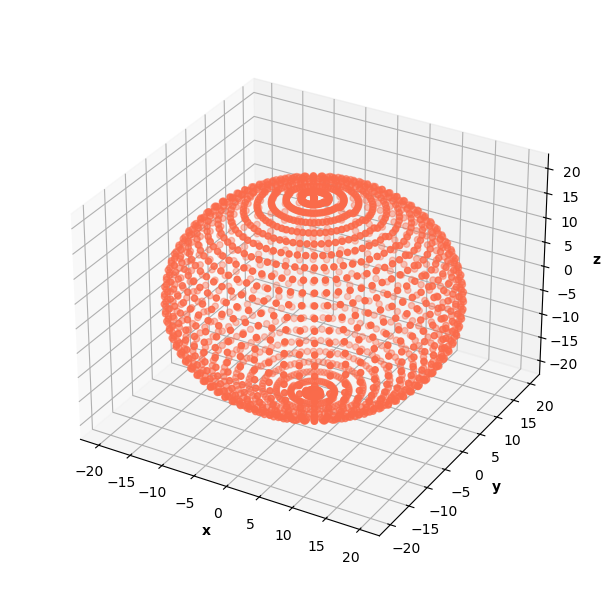

initial sphere shape: (118188, 3)
collocation data shape: (7938, 3)
boundary condition data shape: (882, 3)
total N after over/under sample: 8820
approx. sphere shape: (20480, 3)

train collocation:


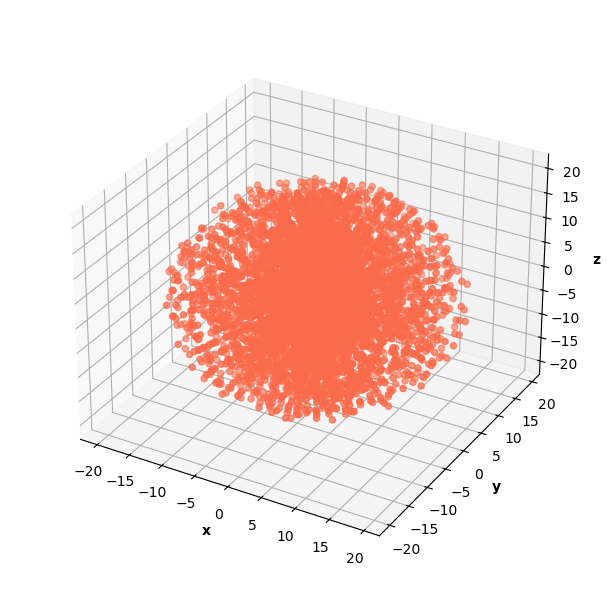

train b.c.:


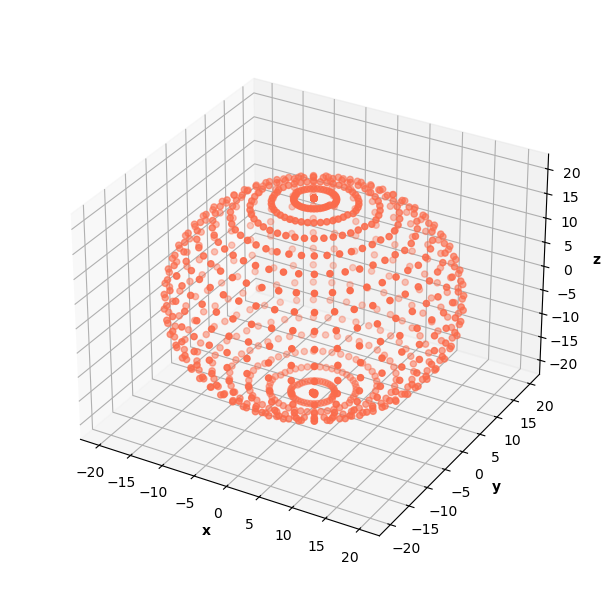

In [ ]:
# set gpu
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

r_max = 20  # maximum radius allowed in data

# generate set of test data and full approximate sphere
dr = 0.1
dt = 0.1
dp = 0.1
coll_data, bc_data, bc_u, coll_data_sp, bc_data_sp, full_sp, full_cart = gen_sphere_data(r_max, 2 * np.pi, np.pi, dr, dt, dp)
print()
print("approximate sphere domain:")
visualize(full_cart)
print("test collocation:")
visualize(coll_data)
print("test b.c.:")
visualize(bc_data)

# generate set of train data
dr_train = 0.15
dt_train = 0.15
dp_train = 0.15
train_coll_data, train_bc_data, train_bc_u, train_coll_data_sp, train_bc_data_sp, _, _ = gen_sphere_data(r_max, 2 * np.pi, np.pi, dr_train, dt_train, dp_train)
print()
print("train collocation:")
visualize(train_coll_data)
print("train b.c.:")
visualize(train_bc_data)

# cast arrays to tensors
coll_data = torch.tensor(coll_data, requires_grad=True).to(device)
bc_data = torch.tensor(bc_data, requires_grad=True).to(device)
bc_u = torch.tensor(bc_u, requires_grad=True).to(device)
full_sp = torch.tensor(full_sp, requires_grad=True).to(device)  
full_cart = torch.tensor(full_cart, requires_grad=True).to(device)  
train_coll_data = torch.tensor(train_coll_data, requires_grad=True).to(device)
train_bc_data = torch.tensor(train_bc_data, requires_grad=True).to(device)
train_bc_u = torch.tensor(train_bc_u, requires_grad=True).to(device)

### loss class definition

In [19]:
class PINNLoss(nn.Module):
    def __init__(self):
        super(PINNLoss, self).__init__()
        self.loss = None

        # NOTE if you change loss terms returned, must change this and return+calculations in calc_loss()
        self.return_names = ["loss_ovr", "loss_ovr_no_reg", "loss_f", "loss_bc", "u_trivial_penalty"]
    
    def MSE_f(self, f_pred):
        """
        Returns MSE loss on f predictions. 

        Inputs:
        f_pred: batch of differential equation predictions
        """

        return torch.mean(f_pred**2)

    def MSE_bc(self, u_target, u_pred):
        """
        Returns MSE loss on b.c. predictions.

        Inputs:
        u_target: actual value of u
        u_pred: batch of predicted u values at b.c. points
        """

        return torch.mean((u_target - u_pred)**2)

    def calc_u_trivial_penalty(self, u_pred):
        """
        Returns a term that penalizes trivial solutions.

        Inputs:
        u_pred: batch of wavefunction predictions
        """

        return (1 / torch.mean(u_pred**2 + 1e-6))

    def calc_loss(self, u_coll_pred, f_pred, u_bc_target, u_bc_pred):
        """
        Calculate loss terms for predictions. Returns a tuple of losses. 
        Names and order of returned terms should match self.return_names.

        Inputs:
        u_coll_pred: batch of wavefunction predictions 
        f_pred: batch of differential equation predictions (only generated from collocation data)
        u_bc_target: actual u values for b.c. data
        u_bc_pred: batch of b.c. wavefunction predictions
        """

        # differential equation MSE loss (collocation)
        loss_f = self.MSE_f(f_pred)

        # trivial solution penalty (collocation)
        u_trivial_penalty = self.calc_u_trivial_penalty(u_coll_pred)

        # b.c. MSE loss
        loss_bc = self.MSE_bc(u_bc_target, u_bc_pred)

        # overall loss
        loss_ovr = loss_f + loss_bc + u_trivial_penalty 

        # loss w/o regularization terms
        loss_ovr_no_reg = loss_f + loss_bc

        return loss_ovr, loss_ovr_no_reg, loss_f, loss_bc, u_trivial_penalty

### PINN class definition

In [ ]:
class SinActivation(torch.nn.Module):
    @staticmethod
    def forward(input):
        """
        Passes input tensor through sin function. Used in neural network class.

        Inputs:
        input: tensor batch of layer outputs
        """

        return torch.sin(input)

class PINN(nn.Module):
    def __init__(self, input_size, device, E=None, num_hidden_layers=4, optimizer_lr=0.0001, optimizer_betas=(0.999, 0.9999)):
        super(PINN, self).__init__()

        # constants
        self.planck_term_constant = 0.5  # hbar**2/2*m in Coulomb units
        self.charge_term_constant = 1  # e^2/4*pi*epsilon_0 in Coulomb units

        # torch device
        self.device = device

        # input dimensions
        self.input_size = input_size

        # E initialization
        self.E = E

        # network
        self.activation = SinActivation()
        self.dense0 = nn.Linear(input_size + 1, 64, dtype=torch.double)  # NOTE +1 to input shape for implicit E value
        self.hidden_layers = nn.ModuleList([nn.Linear(64, 64, dtype=torch.double) for _ in range(num_hidden_layers)])  # NOTE new
        self.dense_out = nn.Linear(64, 1, dtype=torch.double)

        # optimizer + loss
        self.optimizer = optim.Adam(self.parameters(), lr=optimizer_lr, betas=optimizer_betas)
        self.loss_criteria = PINNLoss()
        self.loss = None

    def scale_output(self, u, zero_thresh=1e-4):
        """
        Zero-scales predictions based on zero_thresh.
        Returns u with abs(predictions) <= zero_thresh changed to 0, other values unchanged.

        Inputs:
        u: network output predictions
        zero_thresh: threshold at which to call predictions zero (<=)
        """

        mask = (~(torch.abs(u) <= zero_thresh)).to(int)

        return u * mask

    def forward_net(self, data):
        """
        Forward pass through full network. Returns network output.

        Inputs:
        data: tensor with correct input shape
        """

        out = self.dense0(data)
        out = self.activation(out)
        for hidden_layer in self.hidden_layers:
            out = hidden_layer(out)
            out = self.activation(out)
        out = self.dense_out(out)
        
        return out

    def forward(self, x, y, z):
        """
        Full PINN forward pass that includes E concat, network forward pass, network output b.c. scaling, 
        gradient calculations, and diff. eqn. (f) calculation.
        Returns final output prediction, u, and f.

        Inputs:
        x: tensor of x with shape (N, 1)
        y: tensor of y with shape (N, 1)
        z: tensor of z with shape (N, 1)
        """

        # create E input vector
        E_batch = torch.tensor([[self.E]] * x.shape[0]).to(self.device)

        # concat inputs for network (need them separate initially for grad calc later)
        nn_inp = torch.cat([x, y, z, E_batch], dim=1)

        # pass through nn
        u = self.forward_net(nn_inp)

        # calc gradients
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]

        u_z = torch.autograd.grad(u, z, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_zz = torch.autograd.grad(u_z, z, grad_outputs=torch.ones_like(u_z), retain_graph=True, create_graph=True)[0]

        # scale 0 predictions
        u = self.scale_output(u)
        
        # differential equation
        r = torch.sqrt(x**2 + y**2 + z**2)
        f = r * self.E * u + r * self.planck_term_constant * (u_xx + u_yy + u_zz) + self.charge_term_constant * u
        
        return u, f

    def forward_inference(self, x, y, z):
        """
        Inference forward pass. Doesn't include gradient + f calculation.

        Inputs:
        x: tensor of x with shape (N, 1)
        y: tensor of y with shape (N, 1)
        z: tensor of z with shape (N, 1)
        """

        # create E input vector
        E_batch = torch.tensor([[self.E]] * x.shape[0]).to(self.device)

        # concat inputs for network 
        nn_inp = torch.cat([x, y, z, E_batch], dim=1)  

        # pass through nn
        u = self.forward_net(nn_inp)

        # scale 0 predictions
        u = self.scale_output(u)

        return u

    def backward(self, u_coll_pred, f_pred, u_bc_target, u_bc_pred):
        """
        Network backward pass. Returns tuple of loss values.
        
        Inputs:
        u_coll_pred: batch of collocation wavefunction predictions 
        f_pred: batch of differential equation predictions
        u_bc_target: actual u values for b.c. data
        u_bc_pred: batch of b.c. wavefunction predictions
        """

        # calculate losses
        losses = self.loss_criteria.calc_loss(u_coll_pred, f_pred, u_bc_target, u_bc_pred)
        self.loss = losses[0]  # NOTE overall loss should always be first value returned in losses tuple

        # backprop + update params
        self.loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return losses 

### plotting functions

In [21]:
def display_plot(x_vals, y_vals, x_label="x", y_label="y", line_color="b", log_scale=False, data_label=None, title=None):
    """
    Generate plot for x_vals and y_vals.

    Inputs:
    pretty self-explanatory
    """

    if data_label:
        plt.plot(x_vals, y_vals, color=line_color, label=data_label)
        plt.legend()
    else:
        plt.plot(x_vals, y_vals, color=line_color)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    if log_scale:
        plt.yscale("log")

    plt.show()

### train loop function

In [22]:
def run_train_loop(coll_data, 
                   bc_data,
                   bc_u,
                   device, 
                   E_range,
                   num_train_steps_per_E,
                   save_denom=1000,
                   loss_criteria_idx=0,
                   num_hidden_layers=4):
    start_time = time.time()
    print(f"training network on {len(E_range)} values of E with {num_train_steps_per_E} train steps per E...")
    epoch = 0
    epoch_print_denom = 1000

    # initialize network
    lr = 8e-3
    betas = (0.999, 0.9999)
    pinn = PINN(coll_data.shape[1], device, optimizer_lr=lr, optimizer_betas=betas, num_hidden_layers=num_hidden_layers)
    pinn.to(device)
    
    # initialize copy of current network (used for tracking best model across training)
    current_best_pinn = PINN(coll_data.shape[1], device, E=pinn.E, optimizer_lr=lr, optimizer_betas=betas, num_hidden_layers=num_hidden_layers).to(device)
    current_best_pinn.load_state_dict(pinn.state_dict())

    # best model save variables
    min_save_epoch = 100
    prev_pinns = []  # list to store best models 
    default_min_loss = 1000
    min_loss = default_min_loss
    current_best_epoch = -1

    E_predictions = []  # track E by training step (epoch)
    train_loss_vals = []  # track all loss values across training

    for E_idx, E in enumerate(E_range):
        # set E
        pinn.E = E
        
        for train_step in range(num_train_steps_per_E):

            # perturb data
            coll_perturbed = perturb_data(coll_data).to(device)

            # collocation forward pass
            u_coll_pred, f_pred = pinn.forward(coll_perturbed[:, 0].reshape(-1, 1), 
                                               coll_perturbed[:, 1].reshape(-1, 1),
                                               coll_perturbed[:, 2].reshape(-1, 1))

            # b.c. forward pass
            u_bc_pred = pinn.forward_inference(bc_data[:, 0].reshape(-1, 1),
                                               bc_data[:, 1].reshape(-1, 1),
                                               bc_data[:, 2].reshape(-1, 1))

            # backward pass
            losses = pinn.backward(u_coll_pred, f_pred, bc_u, u_bc_pred)
            train_loss_vals.append([loss_val.item() for loss_val in losses])

            # track E
            E_predictions.append(E)
            
            ####
            # check if new minimum overall loss attained across this window of epochs
            if (epoch >= min_save_epoch) and (losses[loss_criteria_idx] < min_loss):
                # update current best loss and epoch
                min_loss = losses[loss_criteria_idx]
                current_best_epoch = epoch
                
                # copy current model state 
                current_best_pinn = PINN(coll_data.shape[1], device, E=pinn.E, optimizer_lr=lr, optimizer_betas=betas, num_hidden_layers=num_hidden_layers).to(device)
                current_best_pinn.load_state_dict(pinn.state_dict())

            # save the best (min loss) model across this window of epochs
            if (epoch >= min_save_epoch) and ((epoch + 1) % save_denom == 0):
                min_loss = default_min_loss  # reset min loss to default (ideally next best model beats quickly) 

                # copy this epoch window's best model state and save (model, epoch) tuple to list
                pinn_copy = PINN(coll_data.shape[1], device, E=current_best_pinn.E, optimizer_lr=lr, optimizer_betas=betas, num_hidden_layers=num_hidden_layers).to(device)
                pinn_copy.load_state_dict(current_best_pinn.state_dict())
                prev_pinns.append((pinn_copy, current_best_epoch))

                # NOTE I don't reset current_best_pinn here. so if model in next window doesn't beat default min loss, best model from previous window is saved
            ####

            if ((epoch == 0) or ((epoch + 1) % epoch_print_denom == 0)):
                print("\n" + "=" * 20 + f" EPOCH {epoch} " + "=" * 20)
                print()
                print("train losses:")
                for return_name, val in zip(pinn.loss_criteria.return_names, train_loss_vals[epoch]):
                    print(f"{return_name} = {val:.3e}")
                print()
                print(f"current E = {pinn.E.item()}")
                print(f"elapsed model training time: {(time.time() - start_time) / 60 :.2f} minutes")

            epoch += 1

    # plot losses
    epoch_list = [e for e in range(epoch)]
    for loss_idx, loss_name in enumerate(pinn.loss_criteria.return_names):
        display_plot(epoch_list,
                     torch.tensor(train_loss_vals)[:, loss_idx].detach().numpy(),
                     x_label="epoch",
                     y_label=loss_name,
                     log_scale=True)

    # plot E
    display_plot(epoch_list, E_predictions, x_label="epoch", y_label=r"$\hat{E}$")

    return prev_pinns, train_loss_vals, epoch

### train model(s)

In [ ]:
def calc_E(n):
    """
    Calculates energy based on n in Coulomb units (hbar**2/2m * pi**2/L**2 == 0.5 * pi**2/L**2)
    """

    return -0.5 * (1 / n**2)

n_vals = [1, 2, 3]
E_range = np.array([-0.55, -0.5, -0.45, -0.13, -0.125, -0.12, -0.1, -0.056, -0.01])

training network on 9 values of E with 20000 train steps per E...

==================== EPOCH 0 ====================

train losses:
loss_ovr = 1.218e+02
loss_ovr_no_reg = 2.910e-01
loss_f = 2.827e-01
loss_bc = 8.337e-03
u_trivial_penalty = 1.215e+02

current E = -0.55
elapsed model training time: 0.00 minutes

==================== EPOCH 999 ====================

train losses:
loss_ovr = 5.302e-01
loss_ovr_no_reg = 2.399e-01
loss_f = 2.379e-01
loss_bc = 1.984e-03
u_trivial_penalty = 2.903e-01

current E = -0.55
elapsed model training time: 1.53 minutes

==================== EPOCH 1999 ====================

train losses:
loss_ovr = 3.373e-01
loss_ovr_no_reg = 1.316e-01
loss_f = 1.311e-01
loss_bc = 5.123e-04
u_trivial_penalty = 2.057e-01

current E = -0.55
elapsed model training time: 2.98 minutes

==================== EPOCH 2999 ====================

train losses:
loss_ovr = 2.212e-01
loss_ovr_no_reg = 6.929e-02
loss_f = 6.895e-02
loss_bc = 3.356e-04
u_trivial_penalty = 1.519e-01

curren

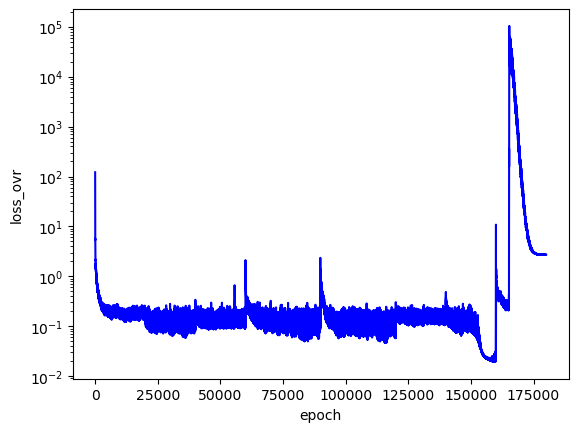

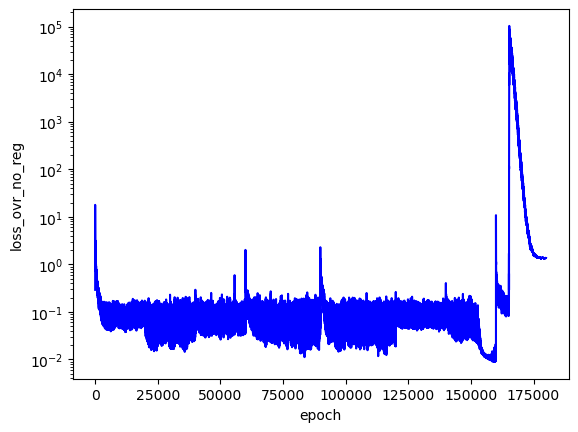

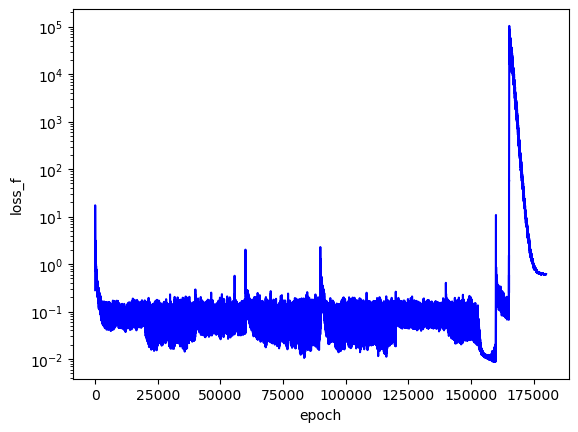

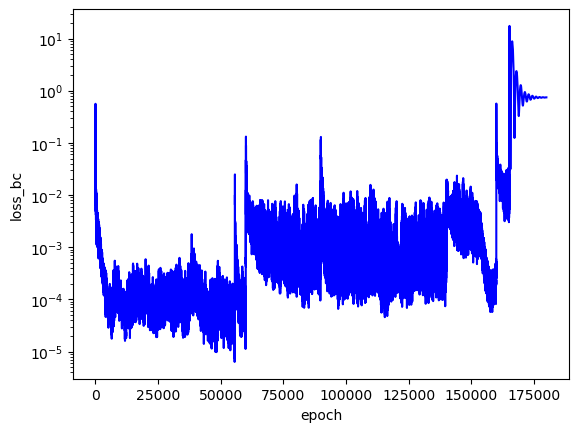

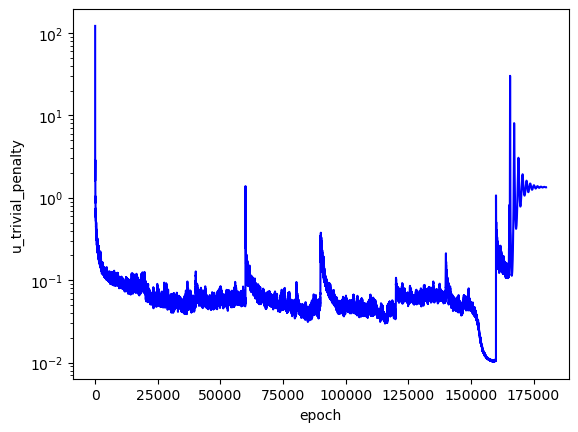

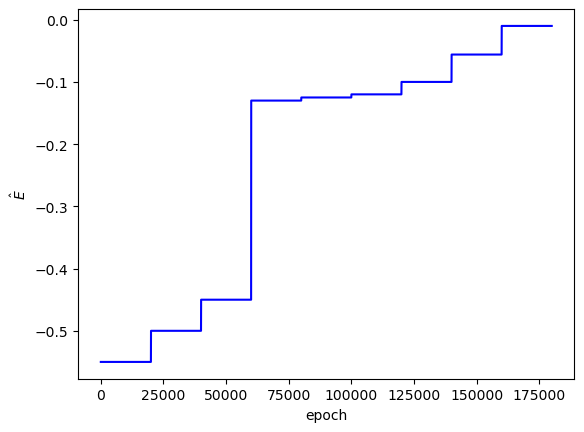

In [24]:
num_train_steps_per_E = 20000
loss_criteria_idx = 1  # loss_f + loss_bc
saved_pinns, train_loss_vals, num_epochs = run_train_loop(train_coll_data, 
                                                          train_bc_data,
                                                          train_bc_u,
                                                          device, 
                                                          E_range, 
                                                          num_train_steps_per_E, 
                                                          loss_criteria_idx=loss_criteria_idx, 
                                                          num_hidden_layers=4)

### get best model(s) and evaluate predictions

In [25]:
def get_best_pinns(min_loss_windows, pinns, train_loss_vals, loss_criteria_idx):
    """
    Plots model with minimum loss (based on loss_criteria_idx) in each window of min_loss_windows.
    Returns list of dictionaries containing the best models + relevant info.

    Inputs:
    min_loss_windows: list of tuples where each tuple is a range of epoch values to look for model with minimum loss
    pinns: list of all saved torch models across training
    train_loss_vals: list of tuples containing loss values for each training epoch
    loss_criteria_idx: index of loss term to use for evaluating best model to save (see PINNLoss)
    """

    ovr_losses = torch.tensor(train_loss_vals)[:, loss_criteria_idx].detach().numpy()
    eigen_pinns = []  # list to save best models to (assuming each model saved below corresponds to unique eigenvalue)

    for (start, stop) in min_loss_windows:
        # find the epoch where the minimum overall loss is achieved
        epoch_idx = np.argmin(ovr_losses[start:stop]) + start

        if (len(pinns) == 0):
            print("No models saved during training.")
        else:
            # get the matching model (this should always hit i think as long as there is a match)
            p_list = [(net, epoch_num) for (net, epoch_num) in pinns if epoch_num == epoch_idx]

            if (len(p_list) == 0):
                print(f"No matching saved models found for epoch window [{start}, {stop}] with minimum epoch = {epoch_idx}. Check self-defined minimum loss windows.")
            else:
                # matching model found
                p = p_list[0]
                
                # save this predicted eigen solution
                eigen_pinns.append({"model": p[0], "epoch": epoch_idx, "losses": train_loss_vals[epoch_idx]})
    
    return eigen_pinns

In [ ]:
loss_windows = [[100 + (i*num_train_steps_per_E * 3), (i*num_train_steps_per_E + num_train_steps_per_E) * 3] for i in range(3)]  # NOTE HARDCODED
best_pinns = get_best_pinns(loss_windows, saved_pinns, train_loss_vals, loss_criteria_idx)
best_pinns

[{'model': PINN(
    (activation): SinActivation()
    (dense0): Linear(in_features=4, out_features=64, bias=True)
    (hidden_layers): ModuleList(
      (0-3): 4 x Linear(in_features=64, out_features=64, bias=True)
    )
    (dense_out): Linear(in_features=64, out_features=1, bias=True)
    (loss_criteria): PINNLoss()
  ),
  'epoch': 35758,
  'losses': [0.07483360569788317,
   0.014424898489133623,
   0.01435354322591135,
   7.135526322227217e-05,
   0.060408707208749544]},
 {'model': PINN(
    (activation): SinActivation()
    (dense0): Linear(in_features=4, out_features=64, bias=True)
    (hidden_layers): ModuleList(
      (0-3): 4 x Linear(in_features=64, out_features=64, bias=True)
    )
    (dense_out): Linear(in_features=64, out_features=1, bias=True)
    (loss_criteria): PINNLoss()
  ),
  'epoch': 83568,
  'losses': [0.04960171993293706,
   0.01117469309028012,
   0.0108531734676059,
   0.00032151962267421946,
   0.03842702684265694]},
 {'model': PINN(
    (activation): SinActi

In [ ]:
def calc_analytical(data_sp, n, l, m):
    """
    Calculates analytical solution for given nlm. Returns np array.

    Inputs:
    data_sp: spherical data with shape (n, 3)
    n: principal quantum number
    l: angular momentum quantum number
    m: magnetic quantum number
    """

    bohr_radius = 1  # Coloumb units 

    if (n == 1):
        return ((1 / np.sqrt(np.pi * bohr_radius**3)) * np.exp(-data_sp[:, 0] / bohr_radius))
    elif (n == 2 and l == 0 and m == 0):
        return (1 / np.sqrt(32 * np.pi * bohr_radius**3)) * (2 - (data_sp[:, 0] / bohr_radius)) * np.exp(-data_sp[:, 0] / (2 * bohr_radius))
    elif (n == 2 and l == 1 and m == 0):
        return (1 / np.sqrt(32 * np.pi * bohr_radius**3)) * (data_sp[:, 0] / bohr_radius) * np.exp(-data_sp[:, 0] / (2 * bohr_radius)) * np.cos(data_sp[:, 1])
    elif (n == 2 and l == 1 and m == 1):
        return (1 / np.sqrt(64 * np.pi * bohr_radius**3)) * (data_sp[:, 0] / bohr_radius) * np.exp(-data_sp[:, 0] / (2 * bohr_radius)) * np.sin(data_sp[:, 1])
    elif (n == 3 and l == 0 and m == 0):
        return (1 / (81 * np.sqrt(3 * np.pi * bohr_radius**3))) * (27 - 18 * data_sp[:, 0] / bohr_radius - 2 * (data_sp[:, 0] / bohr_radius)**2) * np.exp(-data_sp[:, 0] / (3 * bohr_radius)) 
    elif (n == 3 and l == 1 and m == 0):
        return np.sqrt(2) / (81 * np.sqrt(np.pi * bohr_radius**3)) * (6 * data_sp[:, 0] - (data_sp[:, 0] / bohr_radius)**2) * np.exp(-data_sp[:, 0] / (3 * bohr_radius)) * np.cos(data_sp[:, 1])
    elif (n == 3 and l == 1 and m == 1):
        return 1 / (81 * np.sqrt(np.pi * bohr_radius**3)) * (6 * (data_sp[:, 0] / bohr_radius) - (data_sp[:, 0] / bohr_radius)**2) * np.exp(-data_sp[:, 0] / 3) * np.sin(data_sp[:, 1])
    elif (n == 3 and l == 2 and m == 0):
        return 1 / (81 * np.sqrt(6 * np.pi * bohr_radius**3)) * (data_sp[:, 0] / bohr_radius)**2 * np.exp(-data_sp[:, 0] / (3 * bohr_radius)) * (3 * np.cos(data_sp[:, 1])**2 - 1)
    elif (n == 3 and l == 2 and m == 1):
        return 1 / (81 * np.sqrt(np.pi * bohr_radius**3)) * (data_sp[:, 0] / bohr_radius)**2 * np.exp(-data_sp[:, 0] / (3 * bohr_radius)) * (np.sin(data_sp[:, 1]) * np.cos(data_sp[:, 1]))
    elif (n == 3 and l == 2 and m == 2):
        return 1 / (162 * np.sqrt(np.pi * bohr_radius**3)) * (data_sp[:, 0] / bohr_radius)**2 * np.exp(-data_sp[:, 0] / (3 * bohr_radius)) * np.sin(data_sp[:, 1])**2

def calc_pred_norm_const(full_sp_u, full_sp, dr, dt, dp):
    """
    Calculates prediction normalization constant.

    Inputs:
    full_sp_u: network predictions on approximate domain of data (full spherical)
    full_sp: approximate domain of data
    dr: radius step used in full_sp
    dt: theta step used in full_sp
    dp: phi step used in full_sp
    """

    return 1 / torch.sqrt(torch.sum(full_sp_u**2 * full_sp[:, 0].reshape(-1, 1)**2 * torch.sin(full_sp[:, 1].reshape(-1, 1)) * dr * dt * dp))

def make_3D_plot(x_vals, 
                 y_vals, 
                 z_vals, 
                 cmap_vals, 
                 cbar_label="",
                 xlabel="",
                 ylabel="",
                 zlabel="",
                 max_dim=r_max+1
                 ):
    plt.close()
    fig = plt.figure(figsize=(8, 6), constrained_layout=True)
    ax = fig.add_subplot(projection='3d')
    scatter_ax = ax.scatter(x_vals, y_vals, z_vals, c=cmap_vals, cmap="Reds")
    colorbar = fig.colorbar(scatter_ax, shrink=0.55, aspect=6, pad=0.1)
    colorbar.set_label(cbar_label, labelpad=30)
    colorbar.ax.yaxis.label.set_rotation(0)
    ax.set_xlim([-max_dim, max_dim])
    ax.set_ylim([-max_dim, max_dim])
    ax.set_zlim([-max_dim, max_dim])
    ax.set_xlabel(xlabel, weight="bold")
    ax.set_ylabel(ylabel, weight="bold")
    ax.set_zlabel(zlabel, weight="bold")
    ax.zaxis.labelpad = 10
    ax.set_box_aspect(aspect=None, zoom=0.9)  
    plt.show()

def eval_pinn(pinn_dict, coll_data, bc_data, full_sp, full_cart, prob_thresh=0):
    print("=" * 100)
    print(f"PINN saved on epoch {pinn_dict['epoch']}")
    print(f"E = {pinn_dict['model'].E}")
    
    for loss_val, loss_name in zip(pinn_dict["losses"], pinn_dict["model"].loss_criteria.return_names):
        print(f"{loss_name} = {loss_val}")

    # combine bc+coll data for inference
    data = torch.concat([coll_data, bc_data])

    # make predictions on approximate data domain and normalize
    pinn = pinn_dict["model"]
    u_pred = pinn.forward_inference(full_cart[:, 0].reshape(-1, 1), full_cart[:, 1].reshape(-1, 1), full_cart[:, 2].reshape(-1, 1))
    pred_norm_const = calc_pred_norm_const(u_pred, full_sp, 0.5, 0.2, 0.2)  # NOTE hardcoded (same hardcoded step values used to create full_sp)
    print(f"prediction normalization constant: {pred_norm_const}")

    # make predictions on test set (overwrite previous predictions tensor)
    u_pred = pinn.forward_inference(data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1), data[:, 2].reshape(-1, 1))
    u_pred = u_pred * pred_norm_const
    u_pred = u_pred.flatten().detach().cpu().numpy()
    u_pred_prob_densities = u_pred**2
    x = data[:, 0].detach().cpu().numpy()
    y = data[:, 1].detach().cpu().numpy()
    z = data[:, 2].detach().cpu().numpy()
    r = np.sqrt((x**2 + y**2 + z**2))

    # predicted wavefunction vs. r
    plt.close()
    plt.scatter(r, u_pred, color="b", s=5)
    plt.xlabel("r")
    plt.ylabel(r"$\hat{\psi}$")
    plt.show()

    # subset predictions to points with prob density values greater than prob_thresh
    pred_prob_thresh_idx = np.where(u_pred_prob_densities > prob_thresh)[0]
    data_sub = data[pred_prob_thresh_idx]
    u_pred_prob_densities_sub = u_pred_prob_densities[pred_prob_thresh_idx]

    # cut away a corner of data for visualization purposes
    mask = ~((data_sub[:, 0] > 0) & (data_sub[:, 1] < 0))
    data_mask = data_sub[mask]
    u_pred_prob_densities_mask = u_pred_prob_densities_sub[mask.detach().cpu().numpy()]

    # visualize final subset of predictions
    data_mask_detach = data_mask.detach().cpu().numpy()
    x_mask = data_mask_detach[:, 0]
    y_mask = data_mask_detach[:, 1]
    z_mask = data_mask_detach[:, 2]
    make_3D_plot(x_mask, y_mask, z_mask, u_pred_prob_densities_mask, cbar_label=r"$|\hat{\psi}(x,y,z)|^2$", xlabel="x", ylabel="y", zlabel="z")
    
    # f values
    plt.close()
    _, f_pred = pinn.forward(coll_data[:, 0].reshape(-1, 1), coll_data[:, 1].reshape(-1, 1), coll_data[:, 2].reshape(-1, 1))
    f_pred = f_pred.detach().cpu().numpy()
    x_coll = coll_data[:, 0].detach().cpu().numpy()
    y_coll = coll_data[:, 1].detach().cpu().numpy()
    z_coll = coll_data[:, 2].detach().cpu().numpy()
    r_coll = np.sqrt(x_coll**2 + y_coll**2 + z_coll**2)
    plt.scatter(r_coll, f_pred, color="b", s=5)
    plt.xlabel("r")
    plt.ylabel("f")
    plt.yscale("log")
    plt.show()
    print(f"max f = {np.max(np.abs(f_pred))}")
    print(f"min f = {np.min(np.abs(f_pred))}")
    print()
    print()

PINN saved on epoch 35758
E = -0.5
loss_ovr = 0.07483360569788317
loss_ovr_no_reg = 0.014424898489133623
loss_f = 0.01435354322591135
loss_bc = 7.135526322227217e-05
u_trivial_penalty = 0.060408707208749544
prediction normalization constant: 0.015968100162293997


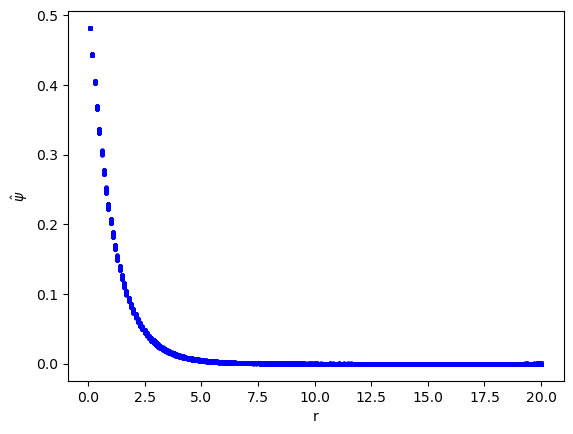

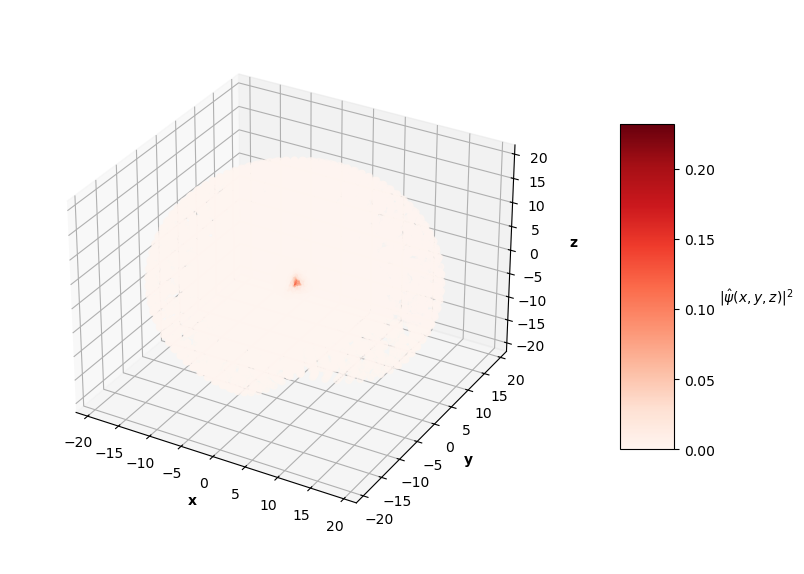

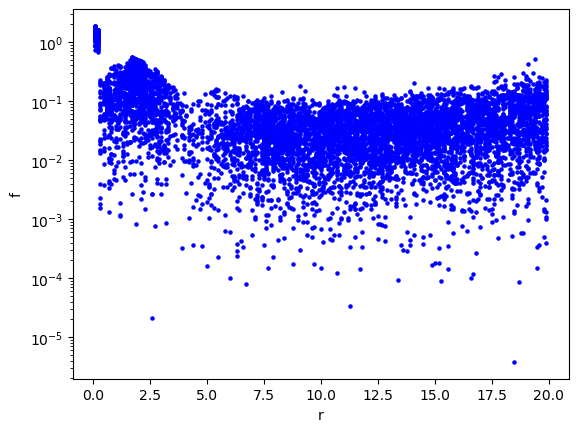

max f = 1.866888054308717
min f = 6.092219332516635e-07


PINN saved on epoch 83568
E = -0.125
loss_ovr = 0.04960171993293706
loss_ovr_no_reg = 0.01117469309028012
loss_f = 0.0108531734676059
loss_bc = 0.00032151962267421946
u_trivial_penalty = 0.03842702684265694
prediction normalization constant: 0.004651503015836567


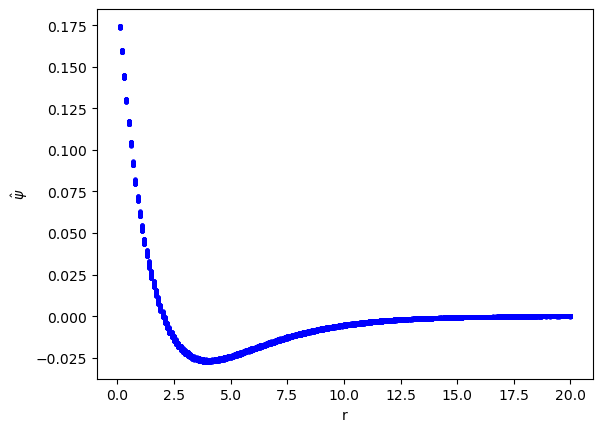

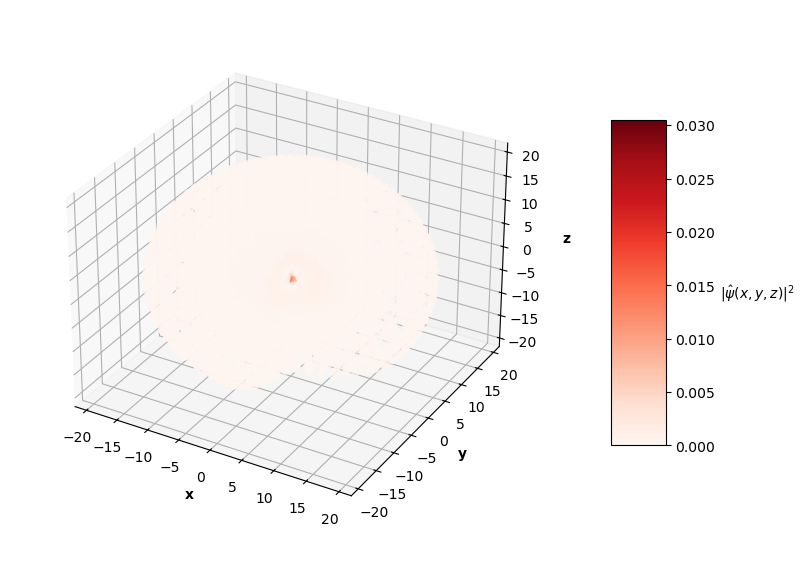

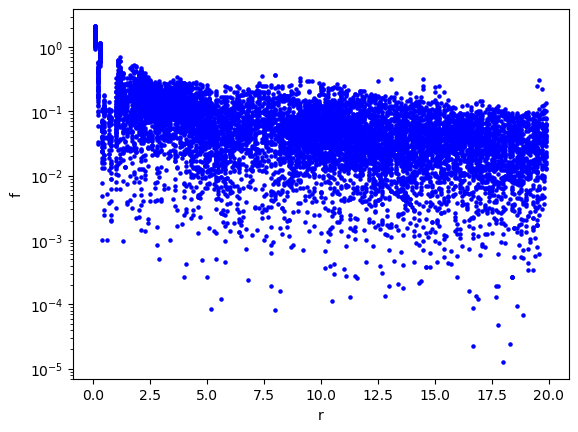

max f = 2.141045657674546
min f = 1.2764049087538032e-05


PINN saved on epoch 159180
E = -0.056
loss_ovr = 0.019283977364069005
loss_ovr_no_reg = 0.008862264234175476
loss_f = 0.008698634310359022
loss_bc = 0.00016362992381645466
u_trivial_penalty = 0.010421713129893527
prediction normalization constant: 0.0010681984289370263


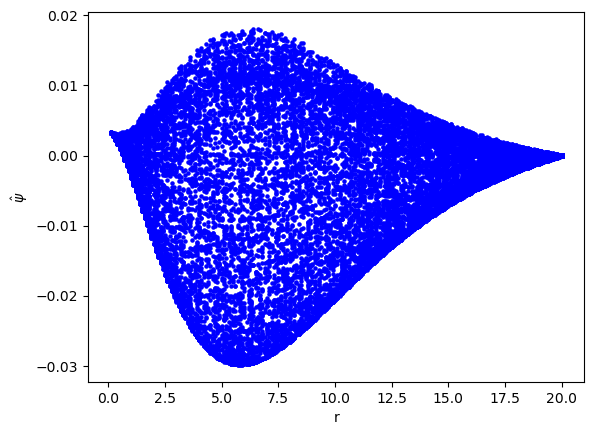

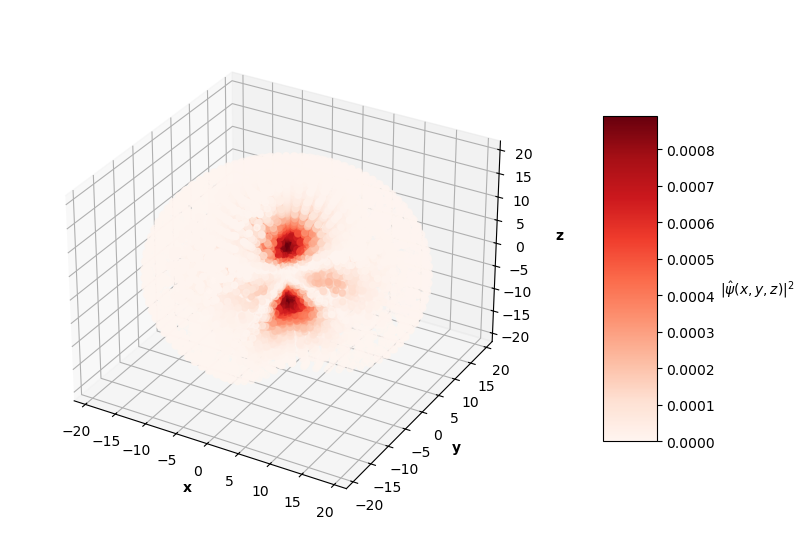

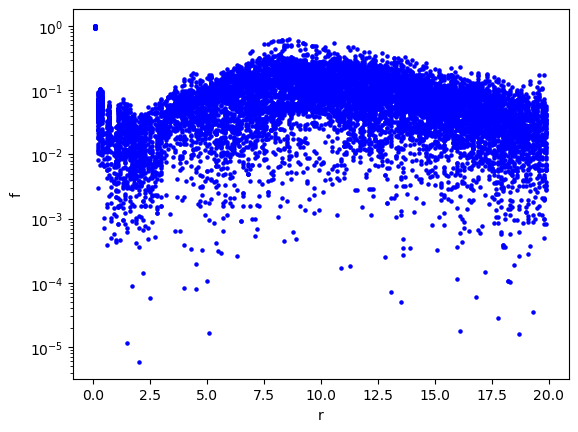

max f = 11.070628544344576
min f = 9.971963610411194e-07




In [ ]:
for pinn_dict, n in zip(best_pinns, n_vals):
    eval_pinn(pinn_dict, coll_data, bc_data, full_sp, full_cart, prob_thresh=0)

### analytical solutions

In [29]:
def check_full_an(n, l, m):
  """
  Hacky function to check analytical solutions. 
  NOTE uses global variables and I don't care.
  """

  data_sp = np.concatenate([coll_data_sp, bc_data_sp])
  u_analytical = calc_analytical(data_sp, n, l, m)
  data = torch.concat([coll_data, bc_data])

  x = data[:, 0].detach().cpu().numpy()
  y = data[:, 1].detach().cpu().numpy()
  z = data[:, 2].detach().cpu().numpy()

  # r vs. wavefunction
  print(f"nlm = {n}{l}{m}")
  plt.close()
  r = np.sqrt(x**2 + y**2 + z**2)
  plt.scatter(r, u_analytical, label="analytical", color="b", s=5)
  plt.xlabel("r")
  plt.ylabel(r"$\psi$")
  plt.legend()
  plt.show()

  # prob density
  u_analytical_prob = u_analytical**2

  # subset to wavefunction values above prob density threshold
  prob_thresh = 0.0
  thresh_idx = np.where(u_analytical_prob > prob_thresh)[0]
  data_sub = data[thresh_idx]
  u_analytical_prob = u_analytical_prob[thresh_idx]

  # slice corner off of visualization
  mask = ~((data_sub[:, 0] > 0) & (data_sub[:, 1] < 0))
  data_mask = data_sub[mask]
  mask = mask.detach().cpu().numpy()
  u_analytical_prob = u_analytical_prob[mask]

  x = data_mask[:, 0].detach().cpu().numpy()
  y = data_mask[:, 1].detach().cpu().numpy()
  z = data_mask[:, 2].detach().cpu().numpy()

  # xyz vs. wavefunction prob density
  make_3D_plot(x, y, z, u_analytical_prob, cbar_label=r"$|\psi(x,y,z)|^2$", xlabel="x", ylabel="y", zlabel="z", max_dim=r_max)

nlm = 100


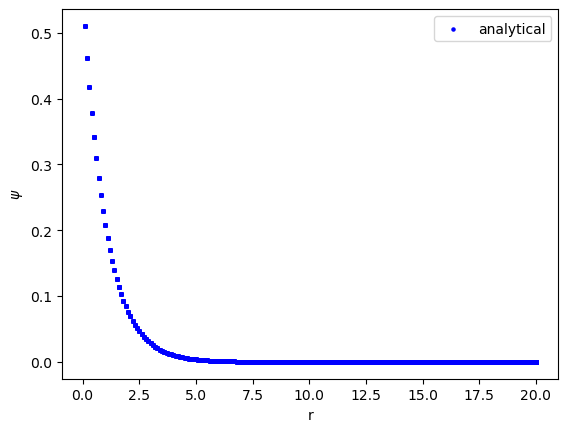

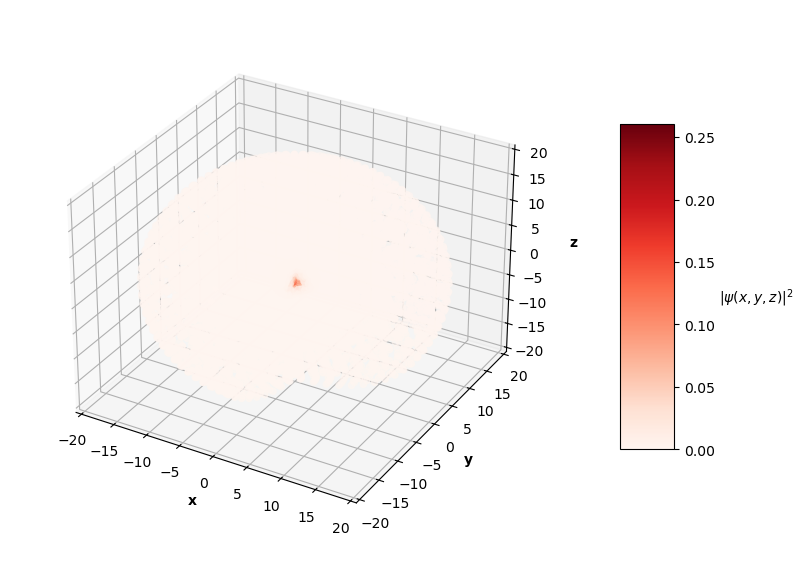

nlm = 200


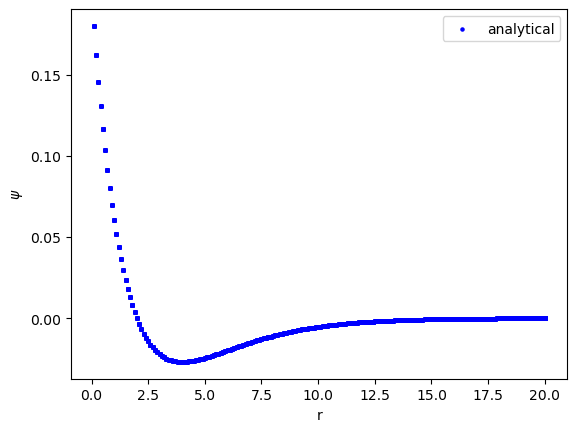

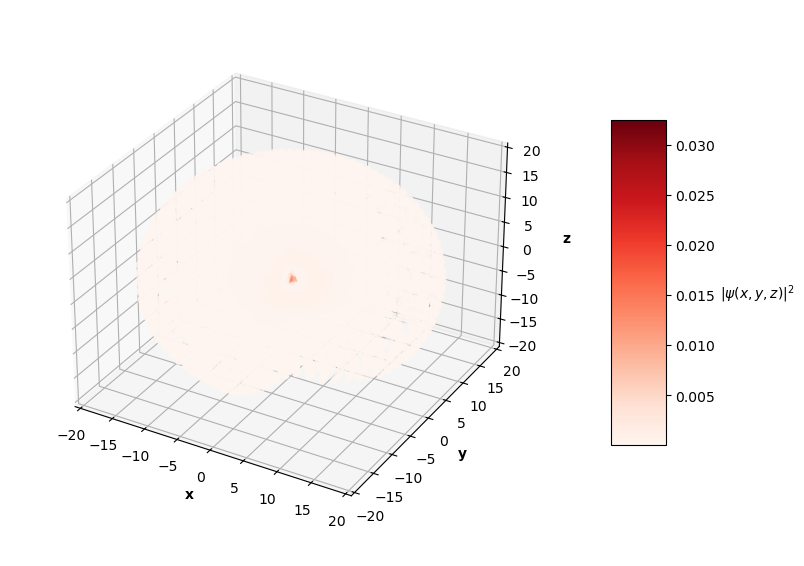

nlm = 210


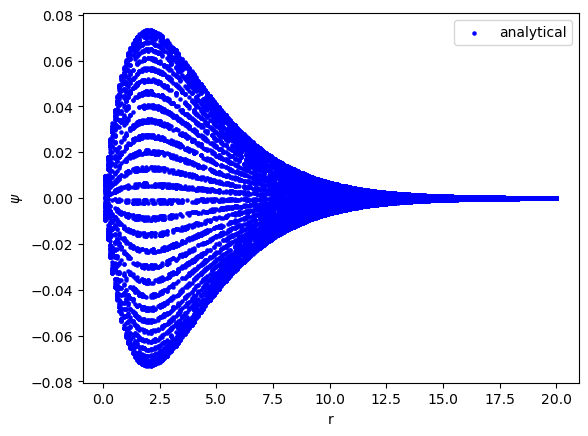

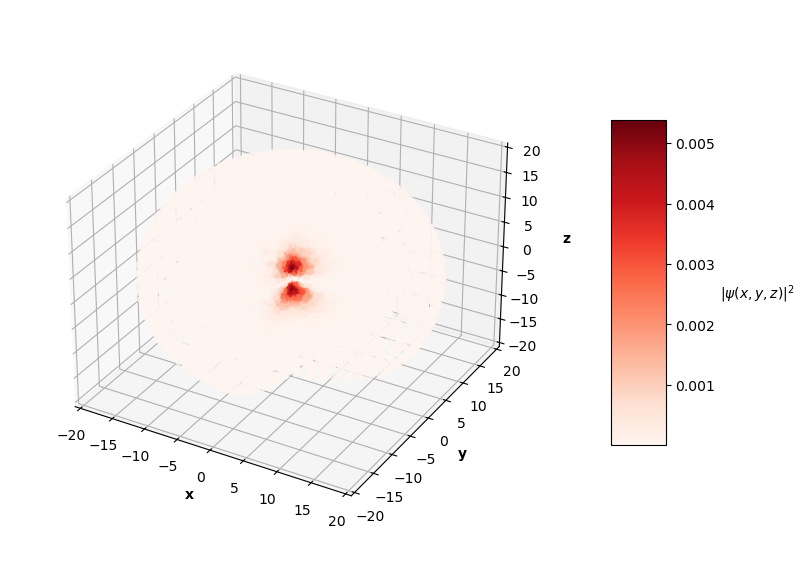

nlm = 211


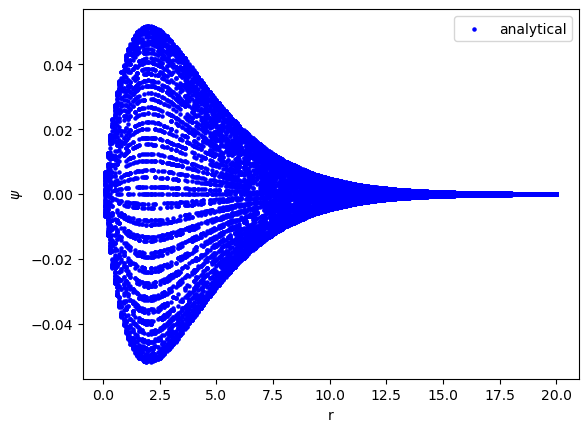

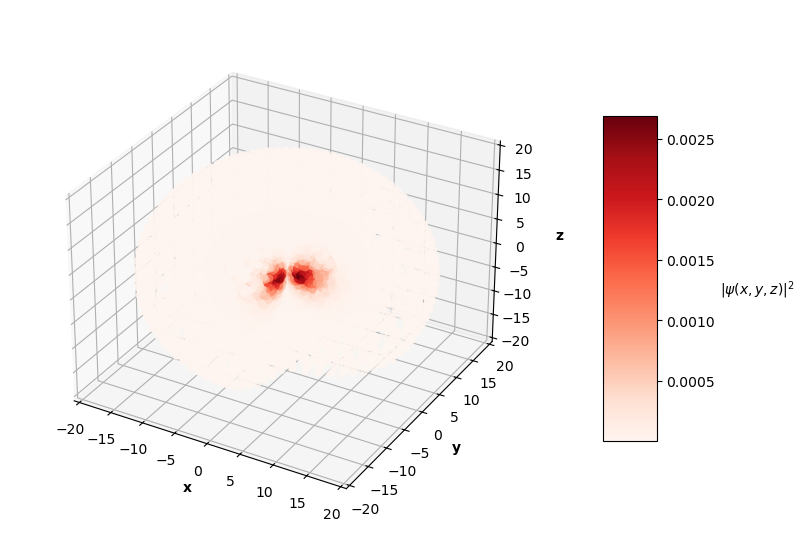

nlm = 300


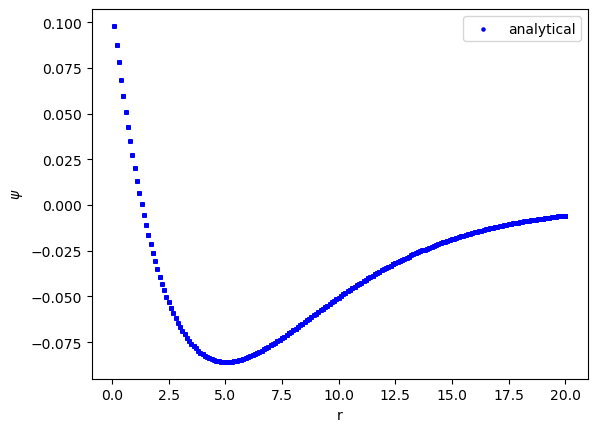

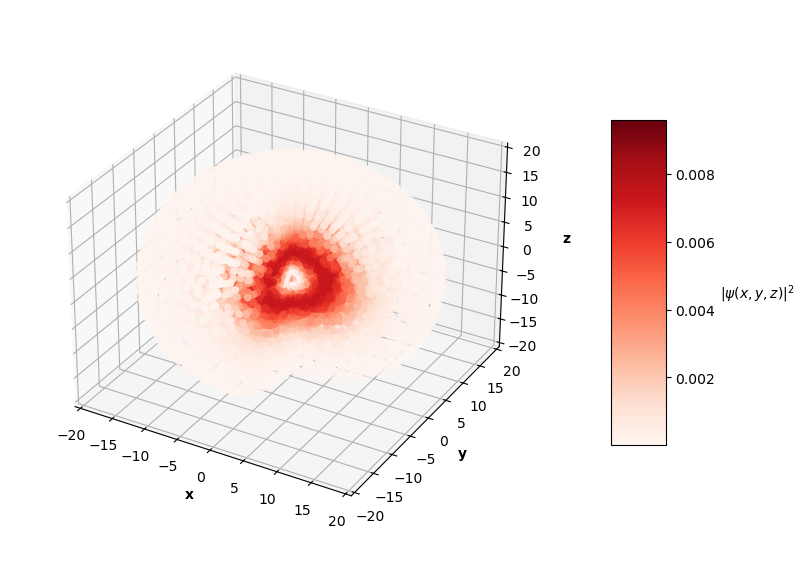

nlm = 310


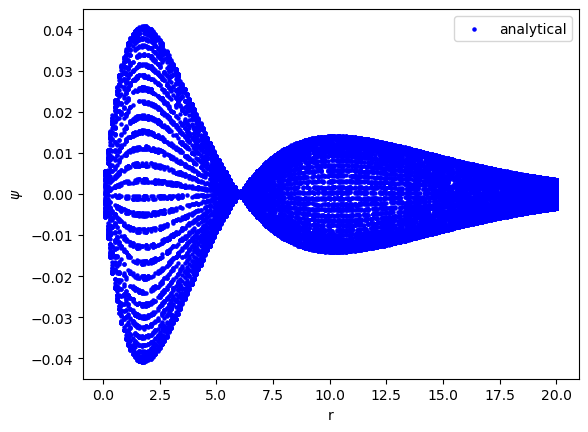

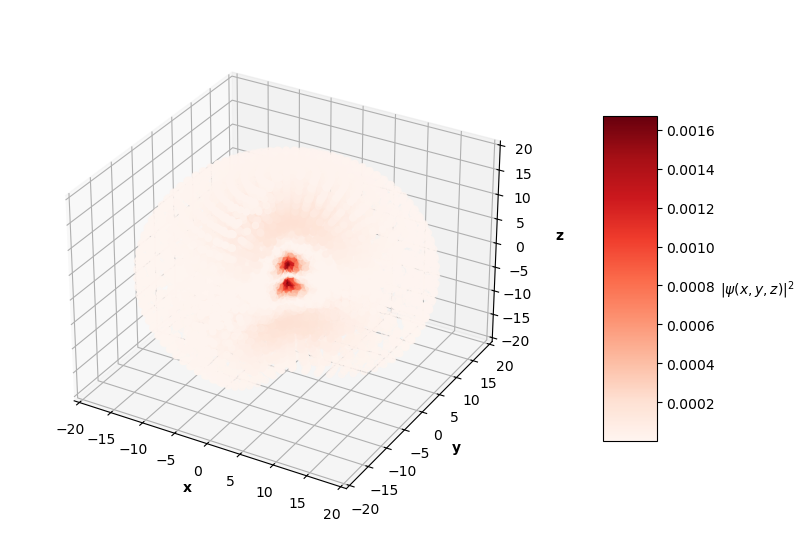

nlm = 311


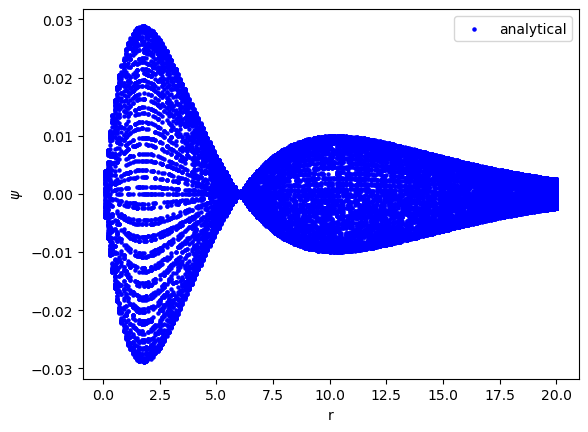

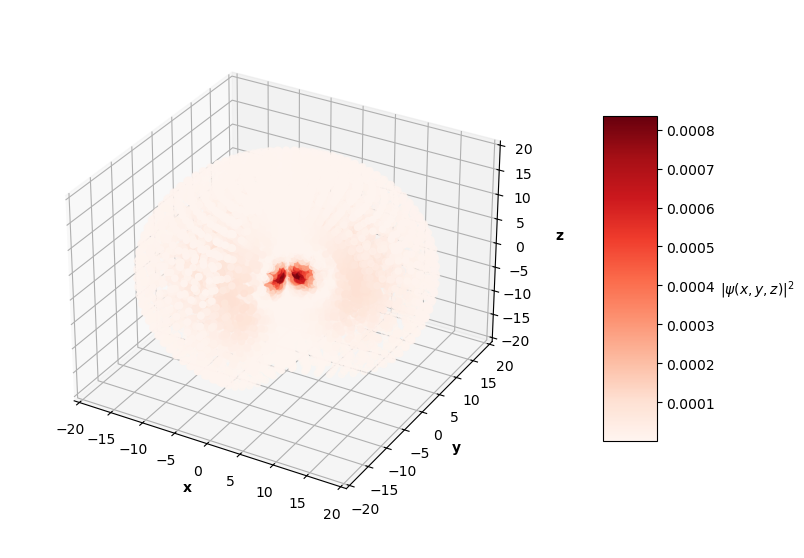

nlm = 320


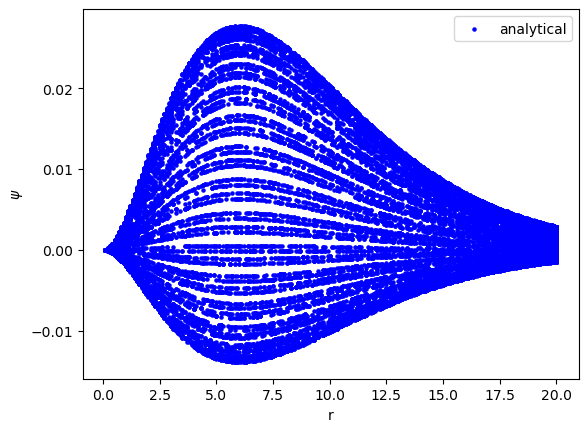

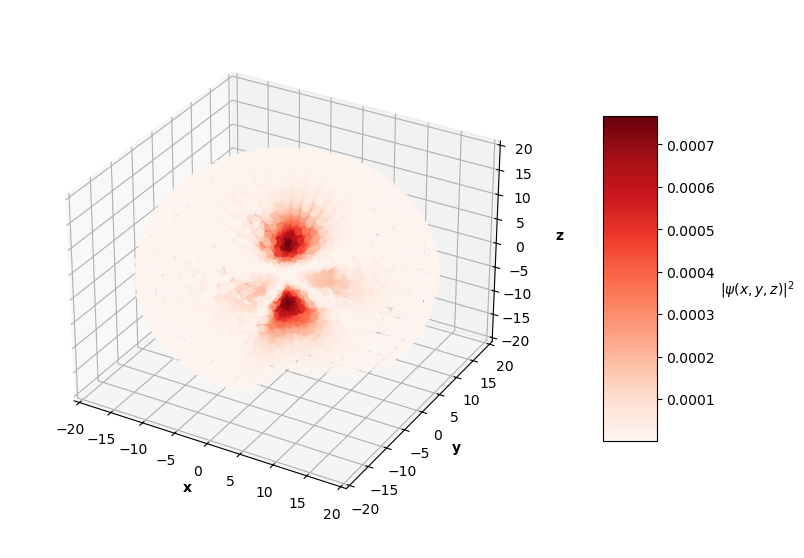

nlm = 321


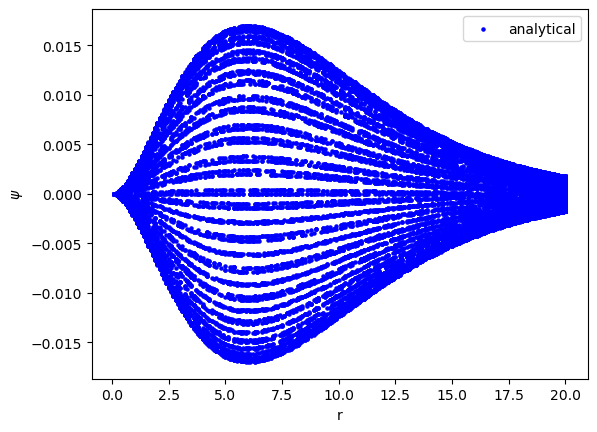

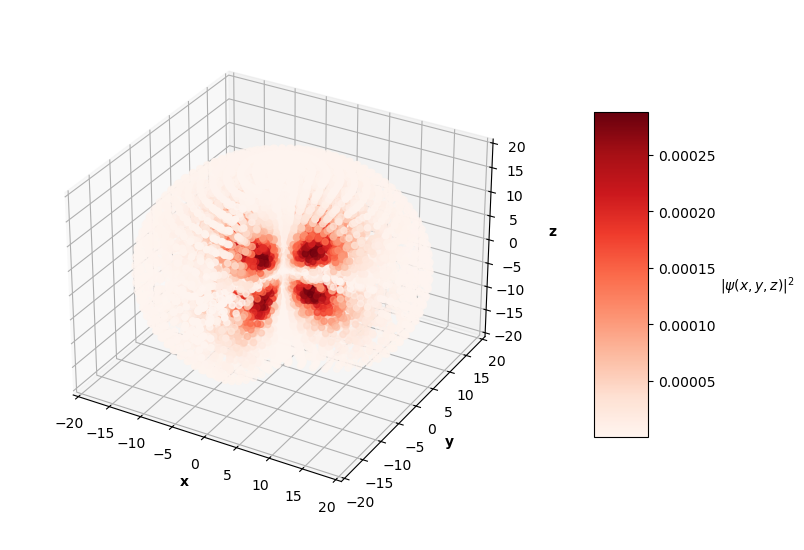

nlm = 322


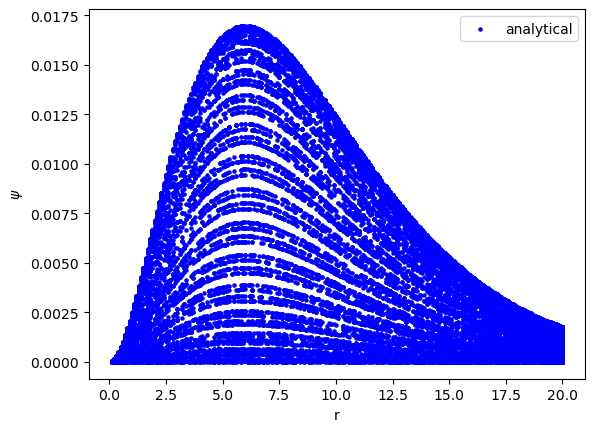

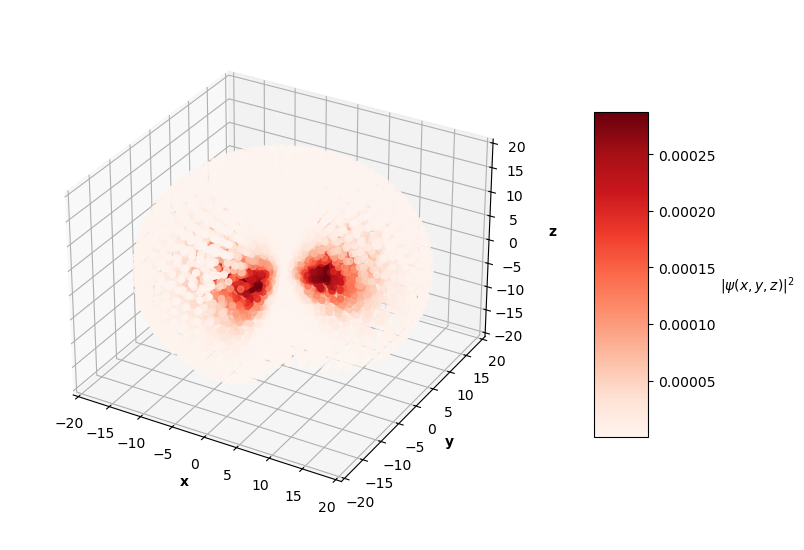

In [30]:
nlm_combos = [(1, 0, 0), (2, 0, 0), (2, 1, 0), (2, 1, 1), (3, 0, 0), (3, 1, 0), (3, 1, 1), (3, 2, 0), (3, 2, 1), (3, 2, 2)]
for n, l, m in nlm_combos:
  check_full_an(n, l, m)